<a href="https://colab.research.google.com/github/christopher-reed/CA-High-Value-Crops/blob/master/PRISM_Data_Demo_bloated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The goal of this notebook is to generate monthly weather data for California counties from [PRISM data](http://www.prism.oregonstate.edu/). This involves an exploration of numpy arrays, Cartopy, Xarray, and masks.**

# Introduction to PRISM Data

We will start working with a small set of PRISM data (one variable, one month) to get a feel for how the data works. I referenced the[PyMorton blog](https://pymorton.wordpress.com/) to learn how to work with PRISM data.

**Import necessary packages.**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from osgeo import gdal
from ftplib import FTP
import xarray as xr

**Use FTP to get zip file containing the data of interest. PRISM FTP information cn be found [here](http://prism.oregonstate.edu/documents/PRISM_downloads_FTP.pdf).**

In [0]:
#Use FTP to download a dataset

#Base address
ftp = FTP('prism.nacse.org')

#Login
ftp.login()

#Specify directory
ftp.cwd('/monthly/tmax/2004')

#Variable of interest
variable = 'PRISM_tmax_stable_4kmM3_200404_bil'

#Specify zip file
file = variable + '.zip'

#Download
ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

#Close connection
ftp.close()

**Unzip the zip file.**

In [20]:
#Unzip file
!unzip $file

Archive:  PRISM_tmax_stable_4kmM3_200404_bil.zip
replace PRISM_tmax_stable_4kmM3_200404_bil.bil? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: PRISM_tmax_stable_4kmM3_200404_bil.bil  
  inflating: PRISM_tmax_stable_4kmM3_200404_bil.hdr  
  inflating: PRISM_tmax_stable_4kmM3_200404_bil.prj  
  inflating: PRISM_tmax_stable_4kmM3_200404_bil.bil.aux.xml  
  inflating: PRISM_tmax_stable_4kmM3_200404_bil.stx  
  inflating: PRISM_tmax_stable_4kmM3_200404_bil.info.txt  
  inflating: PRISM_tmax_stable_4kmM3_200404_bil.stn.csv  
  inflating: PRISM_tmax_stable_4kmM3_200404_bil.xml  


**Read the bil file. Reading the bil file will give you an array of values that represent the variable of interest.**

In [0]:
#Path to bil file
prism_path = variable+ '.bil'

#Read using gdal
prism_ds = gdal.Open(prism_path)
prism_band = prism_ds.GetRasterBand(1)
prism_array = prism_band.ReadAsArray().astype(np.float32)

**We have an array of values from the bil file. The associated hdr file contains information that we need to visualize that array. Create a function to read the hdr value and then extract the critical information.**

In [0]:
#Function to read hdr file

def read_prism_hdr(hdr_path):
    with open(hdr_path, 'r') as input_f:
        header_list = input_f.readlines()
    return dict(item.strip().split() for item in header_list)

**Employ the above function and extract the relevant information from the returned dictionary.**

In [0]:
#Dictionary containing parameters from hdr file
params_dict = read_prism_hdr(variable+'.hdr')

#Extract columns and rows
prism_cols = int(params_dict['NCOLS'])
prism_rows = int(params_dict['NROWS'])

#Extract no data value
prism_nodata = float(params_dict['NODATA'])

#Extract upper left lat and lon
prism_upperleftlon = float(params_dict['ULXMAP'])
prism_upperleftlat = float(params_dict['ULYMAP'])

#Extract the steps for lat and lon
prism_lat_step = float(params_dict['YDIM'])
prism_lon_step = float(params_dict['XDIM'])

**The prism_nodata variable contains the value which indicates a missing observation. In this case, if we observe an observation like -9999 we know this is a missing value. Our current prism_array may have missing values that we do not want to be interpreted as temperature variables. Set the no data values to nan.**

In [0]:
prism_array[prism_array == prism_nodata] = np.nan

**At this point we can make a crude plot just to make sure everything is working. The x and y axis currently represent the index position of a value in the prism_array.**

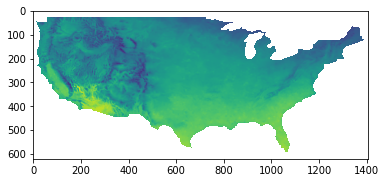

In [28]:
plt.imshow(prism_array, cmap='viridis')

# PRISM and Cartopy

In this section I explore a small set of PRISM data using the Cartopy package. Cartopy will allow me to overlay a layer of boundaries, such as California county boundaries. This [resource](https://uoftcoders.github.io/studyGroup/lessons/python/cartography/lesson/) helped me get started with Cartopy.

**Recipe to [install and run Cartopy in Google Colab](https://github.com/googlecolab/colabtools/issues/85)**

In [29]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

#New addition to fix bug with Google Colab and Shapely (5/2/2020)
!pip install --no-binary shapely shapely --force

Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  libproj-dev proj-bin
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,220 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 232 kB in 1s (369 kB/s)
Selecting previously unselected package libproj-dev:amd64.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...
Unpacking libproj-dev:amd64 (4.9.3-2) ...
Selecting previously unselected package proj-bin.
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.

**Import cartopy packages**

In [0]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

**We are given a starting point in the upper left hand corner of the United States (prism_upperleftlon, prism_upperleftlat) which is around 125W, 49.9N. We are also given the steps (prism_lat_step, prism_lon_step). We can combine the starting point and the steps to find the coordinates of each value.**

In [0]:
#Find the extent of the lat and lon. 
prism_extent = [prism_upperleftlon,
               prism_upperleftlon + (prism_cols * prism_lon_step),
               prism_upperleftlat,
               prism_upperleftlat + (prism_rows * -prism_lat_step)]

#Get all the lats and lons using the extent and step size
lons = np.arange(prism_extent[0], prism_extent[1], prism_lon_step)
lats = np.arange(prism_extent[2], prism_extent[3], -prism_lat_step)

**We can verify our work by including an outline of the United States. Hopefully, all the values fall within the boundaries of the US.**

/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


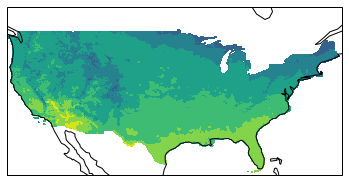

In [0]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.contourf(lons, lats, prism_array)
ax.set_extent([-125, -66.45, 24.041, 49.912])

**It is now a good idea to mesh our latitudes and longitudes so that they are the same shape. After this step we can pull the same index from mesh_lons and mesh_lats and this can be read as a coordinate point. I don't use the meshed lats and lons later, but I thought this may be helpful in a later analysis.**

In [0]:
#Mesh lats and lons together so they are the same shape
mesh_lons, mesh_lats = np.meshgrid(lons, lats)

**Download the most recent county lines from the US Census. Do not run the next cell if you already have them! Takes about 3 minutes.**

In [0]:
#Use FTP to download a dataset

#Base address
ftp = FTP('ftp2.census.gov')

#Login
ftp.login()

#Specify directory
ftp.cwd('/geo/tiger/TIGER2019/COUNTY')

#File of interest
variable = 'tl_2019_us_county'

#Specify zip file
file = variable + '.zip'

#Download
ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

#Close connection
ftp.close()

**Unzip the counties file.**

In [0]:
#All US counties
!unzip tl_2019_us_county.zip

Archive:  tl_2019_us_county.zip
 extracting: tl_2019_us_county.cpg   
  inflating: tl_2019_us_county.dbf   
  inflating: tl_2019_us_county.prj   
  inflating: tl_2019_us_county.shp   
  inflating: tl_2019_us_county.shp.ea.iso.xml  
  inflating: tl_2019_us_county.shp.iso.xml  
  inflating: tl_2019_us_county.shx   


**Create a county lines feature that we can add to the map of the United States.**

In [0]:
#Read the shapefile (all US counties)
reader = shpreader.Reader('tl_2019_us_county.shp')

#Extract geometries from each county
counties = list(reader.geometries())

#Create a counties feature.
counties_feature = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

**Alternativly we can use add_geometries to only include the counties in California. Each item in reader.records has a set of attributes that we can use to filter to only the counties we are interested in.**

/usr/local/lib/python3.6/dist-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'center'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturaleart

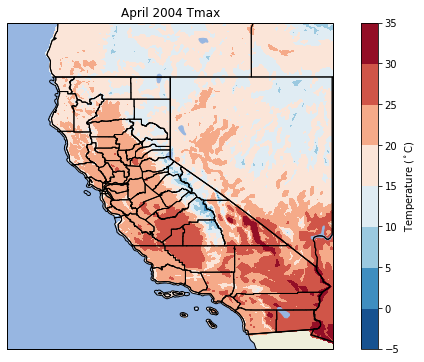

In [0]:
#Read the shapefile (all US counties)
reader = shpreader.Reader('tl_2019_us_county.shp')

#Create figure
fig, ax = plt.subplots( nrows=1, ncols=1, \
                       subplot_kw={'projection': ccrs.PlateCarree()}, \
                       figsize=(10,6) )

#Feature addition
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'black')
ax.add_feature(cfeature.BORDERS)

#Add only CA counties
for county in reader.records():
  if county.attributes['STATEFP'] == '06':
    ax.add_geometries([county.geometry], ccrs.PlateCarree(), edgecolor = 'black', facecolor = 'none')
    
  else:
    continue


#Add coastlines
ax.coastlines('50m')

#Add data
im = ax.contourf(lons, lats, prism_array, cmap = 'RdBu_r', center = 0)

#Adjust extent of map
ax.set_extent([-126, -114, 44, 32])

#Color bar
cbar = plt.colorbar(im)

#Labels
ax.set_title('April 2004 Tmax')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')

plt.show()

**We could have also made a map using the county feature that we created. This map is not filtered to only the counties in California.**

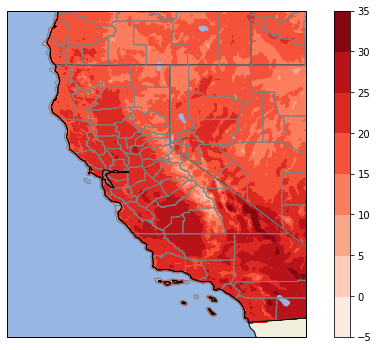

In [0]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

#Feature addition
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'black')
ax.add_feature(counties_feature, facecolor='none', edgecolor='gray')
ax.add_feature(cfeature.BORDERS)

#Add coastlines
ax.coastlines('50m')

#Add data
im = ax.contourf(lons, lats, prism_array, cmap = 'Reds')

#Adjust extent of map
ax.set_extent([-126, -115, 44, 32])

#Color bar
plt.colorbar(im)

plt.show()

# Xarray Datasets

One useful format we can store our information in is a [xarray dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html). [Xarray](http://xarray.pydata.org/en/stable/) is a Python package designed to store multidimensional datasets. This is the perfect fit for us because our data has three dimensions: latitude, longitude, and time. Since we are just starting out, we will continue to use only a small dataset.


This [great resource](https://rabernat.github.io/research_computing_2018/xarray.html#Dataset-Creation) helped me learn the ropes!

**Create a small dataset for one month, one year, and one variable. Specify the coordinates as lat and lon. Lat is then refers to the rows of prism_array and lons refers to the colums. That is [lats,lons]:[rows,cols].**

In [0]:
import xarray as xr

#No need to mesh coords because I specify that rows are lats and columns are lons (lat,lon):(row,col)
ds = xr.Dataset({'tmax': (('lat', 'lon'), prism_array)},
                coords = {'lat':lats,
                         'lon': lons,
                         })

**You can create a map using cartopy directly from the dataset using ds.sel() to select your variable. Learn more about [indexing and selecting in Xarray](http://xarray.pydata.org/en/stable/indexing.html).**

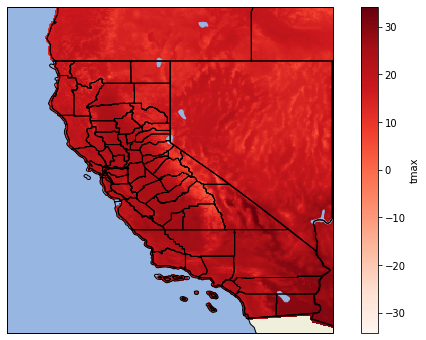

In [0]:
#Create figure
fig, ax = plt.subplots( nrows=1, ncols=1, \
                       subplot_kw={'projection': ccrs.PlateCarree()}, \
                       figsize=(10,6) )

#Using sel() to extract data from datasets.
tmax = ds.tmax.sel()

#Feature addition
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'black')
ax.add_feature(cfeature.BORDERS)

#Add only CA counties
for county in reader.records():
  if county.attributes['STATEFP'] == '06':
    ax.add_geometries([county.geometry], ccrs.PlateCarree(), edgecolor = 'black', facecolor = 'none')
    
  else:
    continue


#Add coastlines
ax.coastlines('50m')

#Just CA
ax.set_extent([-126, -114, 44, 32])

tmax.plot(ax=ax, cmap = 'Reds')

plt.show()

**Previous example only had two dimension: latitude and longitude. Time is another dimension that is important for this project. In order to do this we will need to download more data. The following code downloads 12 months of data for Tmax in 2004.**

In [0]:
#Use FTP to download a dataset

#Months
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

#Download the zip files
for month in months:

  #Base address
  ftp = FTP('prism.nacse.org')

  #Login
  ftp.login()

  #Specify directory
  ftp.cwd('/monthly/tmax/2004')

  #Variable of interest
  variable = 'PRISM_tmax_stable_4kmM3_2004' + month + '_bil'

  #Specify zip file
  file = variable + '.zip'

  #Download
  ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

  #Close connection
  ftp.close()
  
#Unzip all files
for month in months:
  file = 'PRISM_tmax_stable_4kmM3_2004' + month + '_bil.zip'
  !unzip $file


#Read the bil file for each month and convert to an array
array_dict = {}
array_list = []
for month in months:
  prism_path = 'PRISM_tmax_stable_4kmM3_2004' + month + '_bil.bil'
  prism_ds = gdal.Open(prism_path)
  prism_band = prism_ds.GetRasterBand(1)
  prism_array = prism_band.ReadAsArray().astype(np.float32)
  prism_array[prism_array == prism_nodata] = np.nan
  array_list.append(prism_array)

**The variable array_list is a list of 12 arrays. The next step is to stack these 12 arrays along an additional axis (time) using np.dstack.**

In [0]:
#This is a 3D array where depth is the months in 2004
Tmax_2004 = np.dstack(array_list)

**When building an xarray dataset you must have a variable to represent the coordinates of each point in the array. We already have lists of latitudes and longitudes. Now it is time to build a list of times.**

In [0]:
time = pd.date_range(*(pd.to_datetime(['2004-01', '2004-12']) + pd.offsets.MonthEnd()), freq='M')
time

DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31', '2004-11-30', '2004-12-31'],
              dtype='datetime64[ns]', freq='M')

**Create a dataset with the 3D array. I used the following skeleton code to construct my dataset. Remember that the the 'list of values' for each dimension must be the same length as the length of rows, columns or arrays in that dimension. For example, the time list contains 12 items: one for each month. The lat dimension contains 400 some latitudes: one for each row of the Tmax_2004 array.**



```
xr.Dataset({'name of variable': (['dimension 1', 'dimension 2', 'dimension 3'], array of values),
             coords = {'dimension 1': list of values,
                       'dimension 2': list of values,
                       'dimension 3': list of values}})
```



In [0]:
ds_2004 = xr.Dataset({'tmax': (['lat', 'lon', 'time'], Tmax_2004)},
                coords = {'lat':lats,
                         'lon': lons,
                         'time': time
                         })

**We can use our new dataset to construct a plot for Tmax for every month in 2004.**

In [0]:
def Tmax_2004(month):

  #Create figure
  fig, ax = plt.subplots( nrows=1, ncols=1, \
                         subplot_kw={'projection': ccrs.PlateCarree()}, \
                         figsize=(10,6) )

  #Slice the dataset
  tmax = ds_2004.tmax.sel(time = '2004-'+month)

  #Feature addition
  ax.add_feature(cfeature.LAND.with_scale('50m'))
  ax.add_feature(cfeature.OCEAN.with_scale('50m'))
  ax.add_feature(cfeature.LAKES.with_scale('50m'))
  ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'black')
  ax.add_feature(cfeature.BORDERS)

  #Add only CA counties
  for county in reader.records():
    if county.attributes['STATEFP'] == '06':
      ax.add_geometries([county.geometry], ccrs.PlateCarree(), edgecolor = 'black', facecolor = 'none')

    else:
      continue


  #Add coastlines
  ax.coastlines('50m')

  #Just CA
  ax.set_extent([-126, -114, 44, 32])

  tmax.plot(ax=ax, cmap = 'Reds')

  plt.show()

**Apply our function.**

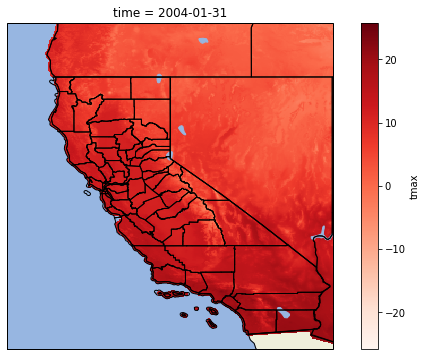

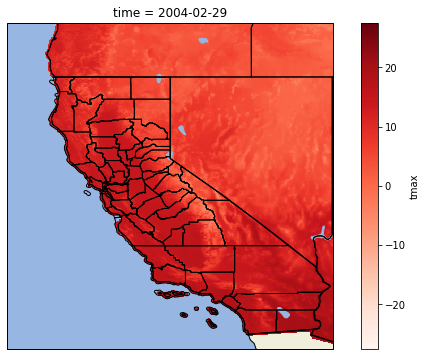

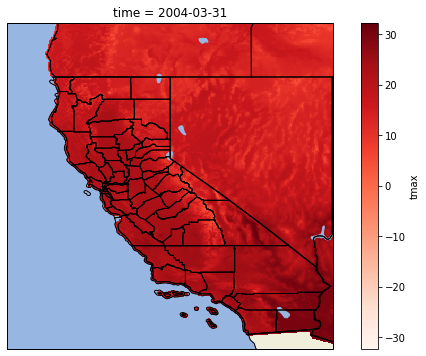

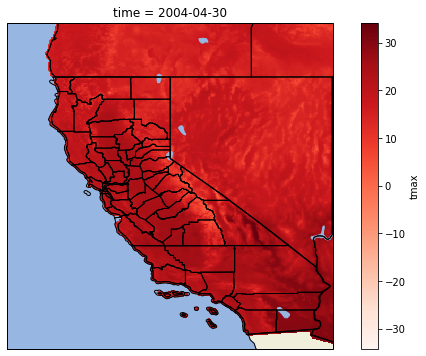

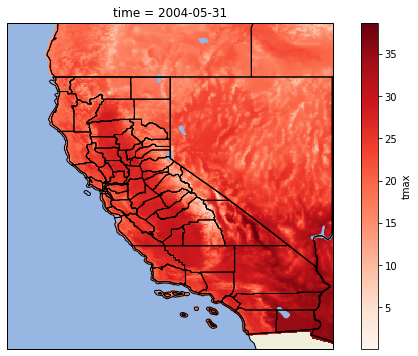

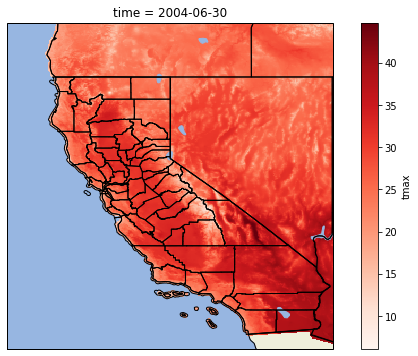

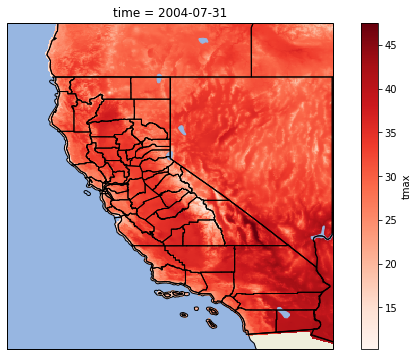

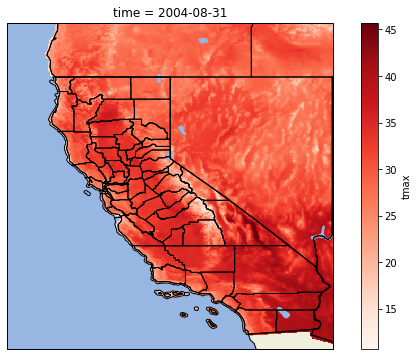

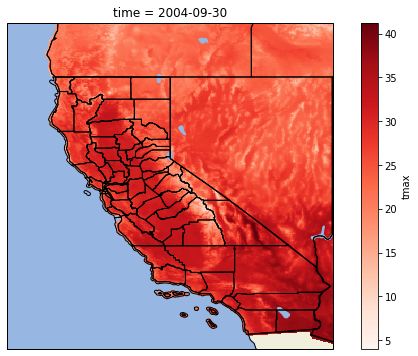

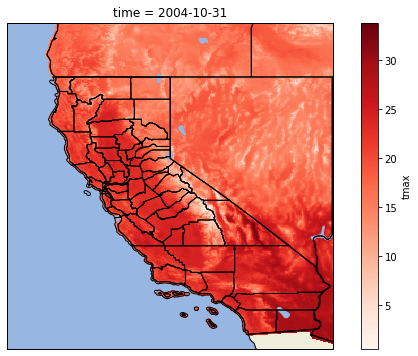

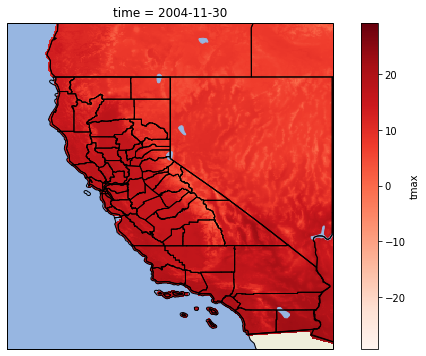

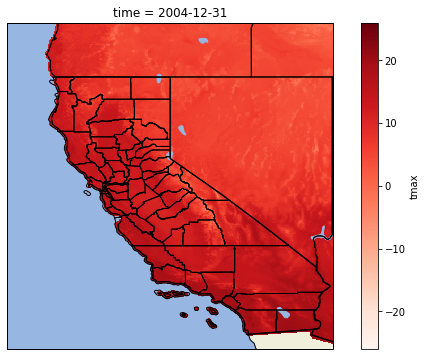

In [0]:
for month in months:
  Tmax_2004(month)

# Xarray Datasets: Multiple years, months, and variables

This section walks through downloading all the data needed for our study. We are interested in collecting monthly data for Tmax, Tmin, Tmean, VPDmax, and VPDmin from 1980 to 2017.

**Use FTP to download the monthly data from 1980 to 2018 (inclusive) for Tmax, Tmin, Tmean, VPDmax, and VPDmin. Unzip each file after downloading it. Instead of cycling through each month as we did in a previous section, it is MUCH faster to download and unzip the file containing all the months in a given year for each variable. These files follow the convention of PRISM_variable_stable_4km(M1 or M2)_year_all_bil. The following cell will take about 10 minutes to run. The resulting files will also take up a considerable amount of space.**

Note to future Chris: File names have changed from M2 to M3. Try to inclue precipitation in this rather than adding it on later. God speed.

In [0]:
#Specify weather variables
weather_vars = ['tmax', 'tmean', 'tmin', 'vpdmax', 'vpdmin'] 

#Years for study
years = list(map(str, np.arange(1980,2019,1)))

#Loop through weather variables
for var in weather_vars:
  
  #Loop through years
  for year in years:
      
      #Base address
      ftp = FTP('prism.nacse.org')

      #Login
      ftp.login()
      
      #Specify directory
      ftp.cwd('/monthly/' + var + '/' + year)
    
      #VPD has M1
      if 'vpd' in var:
        variable = 'PRISM_' + var + '_stable_4kmM3_' + year + '_all_bil'
        
      #Everything else is M2
      else:
        variable = 'PRISM_' + var + '_stable_4kmM3_' + year + '_all_bil'
        
      #Specify zip file
      file = variable + '.zip'

      #Download
      ftp.retrbinary('RETR ' + file, open(file, 'wb').write)
      
      #Unzip
      !unzip $file

Streaming output truncated to the last 5000 lines.
  inflating: PRISM_vpdmax_stable_4kmM3_200309_bil.stx  
  inflating: PRISM_vpdmax_stable_4kmM3_200309_bil.info.txt  
  inflating: PRISM_vpdmax_stable_4kmM3_200309_bil.stn.csv  
  inflating: PRISM_vpdmax_stable_4kmM3_200310_bil.bil  
  inflating: PRISM_vpdmax_stable_4kmM3_200310_bil.hdr  
  inflating: PRISM_vpdmax_stable_4kmM3_200310_bil.prj  
  inflating: PRISM_vpdmax_stable_4kmM3_200310_bil.bil.aux.xml  
  inflating: PRISM_vpdmax_stable_4kmM3_200310_bil.stx  
  inflating: PRISM_vpdmax_stable_4kmM3_200310_bil.info.txt  
  inflating: PRISM_vpdmax_stable_4kmM3_200310_bil.stn.csv  
  inflating: PRISM_vpdmax_stable_4kmM3_200311_bil.bil  
  inflating: PRISM_vpdmax_stable_4kmM3_200311_bil.hdr  
  inflating: PRISM_vpdmax_stable_4kmM3_200311_bil.prj  
  inflating: PRISM_vpdmax_stable_4kmM3_200311_bil.bil.aux.xml  
  inflating: PRISM_vpdmax_stable_4kmM3_200311_bil.stx  
  inflating: PRISM_vpdmax_stable_4kmM3_200311_bil.info.txt  
  inflating: P

**Now we need to make the 3D array for each weather variable. The three dimensions are latitude, longitude, and time. The plan is to make a list of arrays for each variable. The list will be constructed in order from 1980-01 to 2017-12 for each weather variable.**

In [0]:
#Specify weather variables
weather_vars = ['tmax', 'tmean', 'tmin', 'vpdmax', 'vpdmin'] 

#Years for study
years = list(map(str, np.arange(1980,2019,1)))

#Months
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

#Lists to store array
vpdmax_array_list = []
vpdmin_array_list = []
tmax_array_list = []
tmean_array_list = []
tmin_array_list = []


#Cylce through each weather variable for each month within each year.
for year in years:
  
  for month in months:
    
    for var in weather_vars:
      
      
      #Create several elif statements to accomodate each variable.

      
      if var == 'vpdmax':
        
        #Specify path
        prism_path = 'PRISM_' + var + '_stable_4kmM3_' + year + month + '_bil.bil'
        
        #Read bil file
        prism_ds = gdal.Open(prism_path)
        prism_band = prism_ds.GetRasterBand(1)
        prism_array = prism_band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == prism_nodata] = np.nan
        
        #Append array to list
        vpdmax_array_list.append(prism_array)
        
      
      elif var == 'vpdmin':
        
      
        prism_path = 'PRISM_' + var + '_stable_4kmM3_' + year + month + '_bil.bil'
        
        prism_ds = gdal.Open(prism_path)
        prism_band = prism_ds.GetRasterBand(1)
        prism_array = prism_band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == prism_nodata] = np.nan
        
        vpdmin_array_list.append(prism_array)
          
        
      elif var == 'tmax':
        prism_path = 'PRISM_' + var + '_stable_4kmM3_' + year + month + '_bil.bil'
        
        prism_ds = gdal.Open(prism_path)
        prism_band = prism_ds.GetRasterBand(1)
        prism_array = prism_band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == prism_nodata] = np.nan
        
        tmax_array_list.append(prism_array)
        
      elif var == 'tmean':
        prism_path = 'PRISM_' + var + '_stable_4kmM3_' + year + month + '_bil.bil'
        
        prism_ds = gdal.Open(prism_path)
        prism_band = prism_ds.GetRasterBand(1)
        prism_array = prism_band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == prism_nodata] = np.nan
        
        tmean_array_list.append(prism_array)

      elif var == 'tmin':
        prism_path = 'PRISM_' + var + '_stable_4kmM3_' + year + month + '_bil.bil'
        
        prism_ds = gdal.Open(prism_path)
        prism_band = prism_ds.GetRasterBand(1)
        prism_array = prism_band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == prism_nodata] = np.nan
        
        tmin_array_list.append(prism_array)

**We now have five lists of arrays. We can use np.dstack() to stack the arrays in each list. Note that this next cell uses a significant amount of RAM. Your notebook may crash if you have performed other operations.**

In [0]:
Tmax = np.dstack(tmax_array_list)
del tmax_array_list

Tmin = np.dstack(tmin_array_list)
del tmin_array_list

Tmean = np.dstack(tmean_array_list)
del tmean_array_list

VPDmax = np.dstack(vpdmax_array_list)
del vpdmax_array_list

VPDmin = np.dstack(vpdmin_array_list)
del vpdmin_array_list

**As before, we will need to create a list of lats, lons, and time before we create a dataset. We will start with creating a list of dates. Unfortunately, there is no datetime format for only year and month so a list of strings will have to suffice.**

In [0]:
#Create a list of years and months.
time = pd.date_range('1980-01-10','2019-01-07', freq='M').strftime("%Y-%m").tolist()

#The length of the time list should be the the list of arrays (before stacking) of all variables
VPDmin.shape[2] == len(time)

**Now we need the lats and lons. We can read any of the hdr files to get this information because all the files have the same hdr information.**

In [0]:
#Function to read hdr files
def read_prism_hdr(hdr_path):
    """Read an ESRI BIL HDR file"""
    with open(hdr_path, 'r') as input_f:
        header_list = input_f.readlines()
    return dict(item.strip().split() for item in header_list)

  
#Dictionary containing parameters from hdr file
params_dict = read_prism_hdr('PRISM_tmax_stable_4kmM3_200404_bil.hdr')


#Extract columns and rows
prism_cols = int(params_dict['NCOLS'])
prism_rows = int(params_dict['NROWS'])

#Extract no data value
prism_nodata = float(params_dict['NODATA'])

#Extract upper left lat and lon
prism_upperleftlon = float(params_dict['ULXMAP'])
prism_upperleftlat = float(params_dict['ULYMAP'])

#Extract the steps for lat and lon
prism_lat_step = float(params_dict['YDIM'])
prism_lon_step = float(params_dict['XDIM'])


#Find the extent of the lat and lon. 
prism_extent = [prism_upperleftlon,
               prism_upperleftlon + (prism_cols * prism_lon_step),
               prism_upperleftlat,
               prism_upperleftlat + (prism_rows * -prism_lat_step)]

#Get all the lats and lons using the extent and step size
lons = np.arange(prism_extent[0], prism_extent[1], prism_lon_step)
lats = np.arange(prism_extent[2], prism_extent[3], -prism_lat_step)

**Finally we can build our dataset. Refer to an earlier cell where I specified the skeleton for this function xr.Dataset(). This time we have five different variables. Variables and coordinates are stored in seperate dictionaries.**

In [0]:
import xarray as xr

#Create the dataset
ds = xr.Dataset({'tmax': (['lat', 'lon', 'time'], Tmax),
                     'tmin': (['lat', 'lon', 'time'], Tmin),
                     'tmean': (['lat', 'lon', 'time'], Tmean),
                     'vpdmax': (['lat', 'lon', 'time'], VPDmax),
                     'vpdmin': (['lat', 'lon', 'time'], VPDmin)},
                coords = {'lat':lats,
                         'lon': lons,
                         'time': time
                         })

**We can easily convert this dataset to a netCDF file using xarray. This is the preferred storage type that can be easily opened with xarray.**

In [0]:
#Save the dataset as a netCDF
ds.to_netcdf('weather_variables_v2.nc')

**This netCDF file is quite large. It shoud be around 7 GB. I did not want to save this on my local machine so I opted to store it in my Google Drive. I did this by mounting my Google Drive to this notebook (next cell) and then saving it to My Drive (the cell after next).**

In [32]:
#Mount my Google Drive so I can save my file to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Save netCDF file to Google Drive
!cp weather_variables.nc drive/My\ Drive/

In [0]:
!cp weather_variables_v2.nc drive/My\ Drive/

**We can read in our saved dataset as easy as this once Google Drive is mounted to the notebook!**

In [0]:
!pip install netcdf4

In [0]:
#Read in saved file (drive must be mounted). Path will differ depending on 
#where it is saved.
ds = xr.open_dataset('/content/drive/My Drive/weather_variables_v2.nc')

**Check out the data set!**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [34]:
ds

<xarray.Dataset>
Dimensions:  (lat: 621, lon: 1405, time: 468)
Coordinates:
  * lon      (lon) float64 -125.0 -125.0 -124.9 -124.9 ... -66.58 -66.54 -66.5
  * lat      (lat) float64 49.92 49.87 49.83 49.79 ... 24.21 24.17 24.12 24.08
  * time     (time) object '1980-01' '1980-02' '1980-03' ... '2018-11' '2018-12'
Data variables:
    tmax     (lat, lon, time) float32 ...
    tmin     (lat, lon, time) float32 ...
    tmean    (lat, lon, time) float32 ...
    vpdmax   (lat, lon, time) float32 ...
    vpdmin   (lat, lon, time) float32 ...

**I forgot to add the precipitation data! We can put the precip data in a dataarray and then combine that with the dataset to spare our RAM.**

In [35]:
#Specify weather variables
weather_vars = ['ppt'] 

#Years for study
years = list(map(str, np.arange(1980,2019,1)))

#Loop through weather variables
for var in weather_vars:
  
  #Loop through years
  for year in years:
      
    #Base address
    ftp = FTP('prism.nacse.org')

    #Login
    ftp.login()

    #Specify directory
    ftp.cwd('/monthly/' + var + '/' + year)

    #1980 is M2
    if year == '1980':
      variable = 'PRISM_' + var + '_stable_4kmM2_' + year + '_all_bil'

    #1981 onward is M3  
    else:
      variable = 'PRISM_' + var + '_stable_4kmM3_' + year + '_all_bil'

    #Specify zip file
    file = variable + '.zip'

    #Download
    ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

    #Unzip
    !unzip $file

Archive:  PRISM_ppt_stable_4kmM2_1980_all_bil.zip
replace PRISM_ppt_stable_4kmM2_198001_bil.bil? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: PRISM_ppt_stable_4kmM2_198001_bil.bil  
  inflating: PRISM_ppt_stable_4kmM2_198001_bil.hdr  
  inflating: PRISM_ppt_stable_4kmM2_198001_bil.prj  
  inflating: PRISM_ppt_stable_4kmM2_198001_bil.bil.aux.xml  
  inflating: PRISM_ppt_stable_4kmM2_198001_bil.stx  
  inflating: PRISM_ppt_stable_4kmM2_198001_bil.info.txt  
  inflating: PRISM_ppt_stable_4kmM2_198001_bil.stn.csv  
  inflating: PRISM_ppt_stable_4kmM2_198002_bil.bil  
  inflating: PRISM_ppt_stable_4kmM2_198002_bil.hdr  
  inflating: PRISM_ppt_stable_4kmM2_198002_bil.prj  
  inflating: PRISM_ppt_stable_4kmM2_198002_bil.bil.aux.xml  
  inflating: PRISM_ppt_stable_4kmM2_198002_bil.stx  
  inflating: PRISM_ppt_stable_4kmM2_198002_bil.info.txt  
  inflating: PRISM_ppt_stable_4kmM2_198002_bil.stn.csv  
  inflating: PRISM_ppt_stable_4kmM2_198003_bil.bil  
  inflating: PRISM_ppt_stable_4kmM

**Create the array for ppt.**

In [41]:
#Specify weather variables
weather_vars = ['ppt'] 

#Years for study
years = list(map(str, np.arange(1980,2019,1)))

#Months
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

#Lists to store array
ppt_array_list = []

#Cylce through each weather variable for each month within each year.
for year in years:
  print(year)
  for month in months:
    
    for var in weather_vars:
        
      if year == '1980':
        prism_path = 'PRISM_' + var + '_stable_4kmM2_' + year + month + '_bil.bil'

        prism_ds = gdal.Open(prism_path)
        prism_band = prism_ds.GetRasterBand(1)
        prism_array = prism_band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == prism_nodata] = np.nan
        
        ppt_array_list.append(prism_array)
        
      else:
        prism_path = 'PRISM_' + var + '_stable_4kmM3_' + year + month + '_bil.bil'

        prism_ds = gdal.Open(prism_path)
        prism_band = prism_ds.GetRasterBand(1)
        prism_array = prism_band.ReadAsArray().astype(np.float32)
        prism_array[prism_array == prism_nodata] = np.nan

        ppt_array_list.append(prism_array)

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


**Stack the arrays on 3rd axis.**

In [0]:
ppt = np.dstack(ppt_array_list)
del ppt_array_list

**Create dataset.**

In [0]:
ds_precip = xr.Dataset({'ppt':(['lat','lon','time'], ppt)},
                coords = {'lat':lats,
                         'lon': lons,
                         'time': time
                         })

**Merge the two datasets using the original (ds) coordinates.**

In [48]:
all_weather_ds = ds.merge(ds_precip, join = 'left')
all_weather_ds

<xarray.Dataset>
Dimensions:  (lat: 621, lon: 1405, time: 468)
Coordinates:
  * lon      (lon) float64 -125.0 -125.0 -124.9 -124.9 ... -66.58 -66.54 -66.5
  * lat      (lat) float64 49.92 49.87 49.83 49.79 ... 24.21 24.17 24.12 24.08
  * time     (time) object '1980-01' '1980-02' '1980-03' ... '2018-11' '2018-12'
Data variables:
    tmax     (lat, lon, time) float32 ...
    tmin     (lat, lon, time) float32 ...
    tmean    (lat, lon, time) float32 ...
    vpdmax   (lat, lon, time) float32 ...
    vpdmin   (lat, lon, time) float32 ...
    ppt      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan

**Quick spot check via plot.**

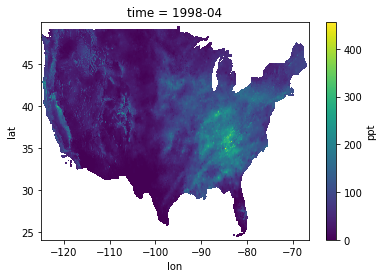

In [49]:
(all_weather_ds.ppt.sel(time = '1998-04')
 .plot())

**Save the complete dataset as a netCDF and put in on Google Drive.**

In [50]:
#Save the dataset as a netCDF
all_weather_ds.to_netcdf('all_weather_ds_v2.nc')

OSError: ignored

In [0]:
!rm /content/PRISM_vpdmin_stable_4kmM3_2018_bil.stx

In [58]:
#Specify weather variables
weather_vars = ['tmax', 'tmean', 'tmin', 'vpdmax', 'vpdmin'] 

#Years for study
years = list(map(str, np.arange(1980,2019,1)))

#Loop through weather variables
for var in weather_vars:
  
  #Loop through years
  for year in years:

        variable = 'PRISM_' + var + '_stable_4kmM3_' + year + '_all_bil.bil'

        !rm /content/$variable
     

rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1980_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1981_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1982_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1983_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1984_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1985_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1986_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1987_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1988_all_bil.bil': No such file or directory
rm: cannot remove '/content/PRISM_tmax_stable_4kmM3_1989_all_bil.bil': No such file or directory
rm: cannot remove '/content/PR

KeyboardInterrupt: ignored

In [0]:
#Save netCDF file to Google Drive
!cp all_weather_ds_v2.nc drive/My\ Drive/

In [0]:
#Read in saved file (drive must be mounted). Path will differ depending on 
#where it is saved.
ds = xr.open_dataset('/content/drive/My Drive/SRP 199 Research/Data/all_weather_ds.nc')

In [0]:
ds

<xarray.Dataset>
Dimensions:  (lat: 621, lon: 1405, time: 456)
Coordinates:
  * lon      (lon) float64 -125.0 -125.0 -124.9 -124.9 ... -66.58 -66.54 -66.5
  * lat      (lat) float64 49.92 49.88 49.83 49.79 ... 24.21 24.17 24.12 24.08
  * time     (time) object '1980-01' '1980-02' '1980-03' ... '2017-11' '2017-12'
Data variables:
    tmax     (lat, lon, time) float32 ...
    tmin     (lat, lon, time) float32 ...
    tmean    (lat, lon, time) float32 ...
    vpdmax   (lat, lon, time) float32 ...
    vpdmin   (lat, lon, time) float32 ...
    ppt      (lat, lon, time) float32 ...

# Mask Creation

The dataset we created encompasses the entire United States. However, we are only interested in counties in California. A common solution is to create masks that hide all values outside of a polygon of interest. There is a [great thread](https://github.com/pydata/xarray/issues/501) on Github explaining how to do this.


**Download and import necessary packages.**

In [0]:
!pip install geopandas
!pip install rasterio
!pip install affine

In [0]:
import geopandas
from rasterio import features
from affine import Affine
import xarray as xr

**Github Example.**

In [0]:
states = geopandas.read_file('ne_10m_admin_1_states_provinces.shp')

us_states = states.query("admin == 'United States of America'").reset_index(drop=True)
state_ids = {k: i for i, k in enumerate(us_states.woe_name)}
shapes = [(shape, n) for n, shape in enumerate(us_states.geometry)]
ds_states = xr.Dataset(coords={'longitude': np.linspace(-125, -65, num=5000),
                          'latitude': np.linspace(50, 25, num=3000)})

In [0]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale


def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['latitude'], coords['longitude'])
    out_shape = (len(coords['latitude']), len(coords['longitude']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

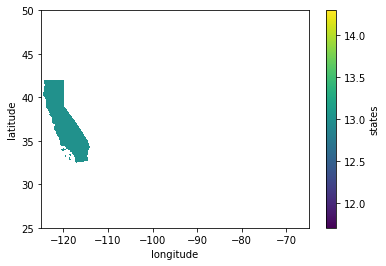

In [0]:
ds_states['states'] = rasterize(shapes, ds_states.coords)

# example of applying a mask
ds_states.states.where(ds_states.states == state_ids['California']).plot()

In [0]:
#Use this array to do arithmetic on California stuff. 
#Seems like lons and lats need to be the same as the data
ds.states.where(ds.states == state_ids['California'])

**Application to California counties. Read the shapefile containing information for all county boundaries in the US.**

In [0]:
#Read file
counties = geopandas.read_file('tl_2019_us_county.shp')

#Inspect the df so we know how to filter to CA
counties.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."


**We are only interested in California counties. Filter to them.**

In [0]:
#Filter
counties = counties[counties['STATEFP'] == '06']

**I took these two functions from the Github thread I references earlier. The functions are responsible for creating the masks.**

In [0]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale


def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['latitude'], coords['longitude'])
    out_shape = (len(coords['latitude']), len(coords['longitude']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

In [0]:
#Create dictionary of county names and ids
county_ids = {k: i for i, k in enumerate(counties['NAME'])}

#Makes list of tuples for the shape and id of each county
county_shapes = [(shape, n) for n, shape in enumerate(counties.geometry)]

#Create a dataset with lats and lons. Lats and lons variables were created earlier
#in the notebook.
ds_counties = xr.Dataset(coords={'longitude': lons,
                          'latitude': lats})

#Apply rasterize function to create masks for counties
ds_counties['counties'] = rasterize(county_shapes,ds_counties.coords)

**We can make a plot where all the counties are shown. The color bar represents the code of each county.**

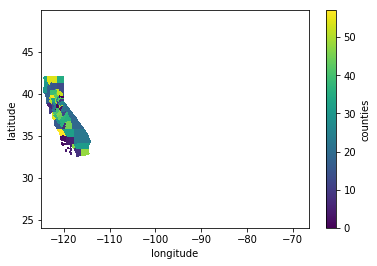

In [0]:
ds_counties.counties.plot()

**We can apply a mask to hide everything BUT Santa Clara county.**

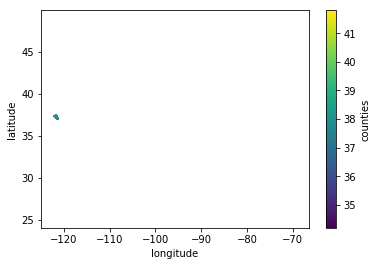

In [0]:
ds_counties.counties.where(ds_counties.counties == county_ids['Santa Clara']).plot()

# Experimenting With Masks

In this section I go over applying multiple masks and how to extract the arrays of values after masks have been applied. I learned much of this from this [resource](https://gist.github.com/shoyer/0eb96fa8ab683ef078eb).


In [0]:
#Load dataset from Google Drive. Drive must be mounted.
ds = xr.open_dataset('/content/drive/My Drive/SRP 199 Research/Data/all_weather_ds.nc')

In [0]:
#Define function to create masks
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

#Read shapefile of all US counties
counties = geopandas.read_file('tl_2019_us_county.shp')

#Filter to California
counties = counties[counties['STATEFP'] == '06']

#Create dictionary of county names and FIPS codes
county_ids = {k: i for i, k in enumerate(counties['NAME'])}

#Zip counties and number
county_shapes = zip(counties.geometry, range(len(counties)))

#Create masks
ds['counties'] = rasterize(county_shapes, ds.coords, longitude='lon', latitude='lat')


**Plot just Santa Clara county with no variables.**

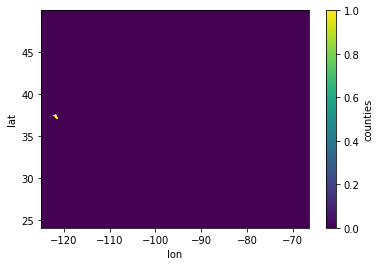

In [0]:
(ds.counties == county_ids['Santa Clara']).plot()

**Plot Tmin in April of 2017 in just Santa Clara county. Note that slice(lon... lat...) will only let you select counties within that slice. This will become important later on.**

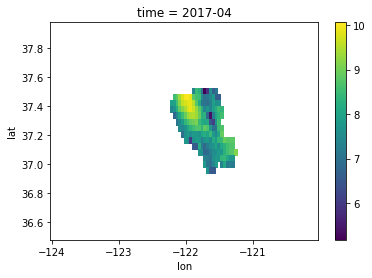

In [0]:
(ds.tmin.sel(time = '2017-04')
 .where(ds.counties == county_ids['Santa Clara'])
 .sel(lon=slice(-124, -120), lat=slice(38, 36.5))
 .plot())

**We can make an even nicer plot by using some of the functionality of cartopy.**

In [0]:
#Next two cells are Santa Clara example

#Create and array for the tmin values in Santa Clara County
array = (ds.tmin.sel(time = '2017-04')
 .where(ds.counties == county_ids['Santa Clara']))

#Lats and Lons
longitude = array.coords['lon'].values
latitude = array.coords['lat'].values

#Go from xarray to np array
array_values = array.values

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'center'
  s)


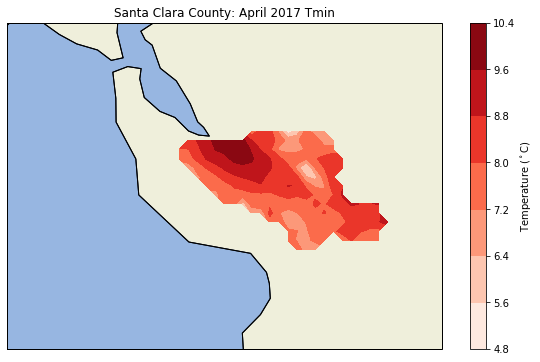

In [0]:
#Create figure
fig, ax = plt.subplots( nrows=1, ncols=1, \
                       subplot_kw={'projection': ccrs.PlateCarree()}, \
                       figsize=(10,6) )

#Add data
im = ax.contourf(longitude, latitude, array_values, cmap = 'Reds', center = 0)

#Feature addition
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'black')
ax.add_feature(cfeature.BORDERS)
ax.coastlines('50m')

#Adjust extent of map
ax.set_extent([-123, -121, 38, 36.5])

#Color bar
cbar = plt.colorbar(im)

#Labels
ax.set_title('Santa Clara County: April 2017 Tmin')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')

plt.show()

**We can also do the entire Bay Area!**

In [0]:
#Next two cells are bay area example

#Counties of interest
counties_list = ['San Mateo', 'Santa Cruz', 'Santa Clara', 'Alameda', 'Contra Costa',
                 'Solano', 'Napa', 'Sonoma', 'Marin', 'San Francisco']

#Creat array for Tmin values during specified date
array = (ds.tmin.sel(time = '2017-04')
 .where(ds.counties.isin(county_fips)))

#Lat and lon data
longitude = array.coords['lon'].values
latitude = array.coords['lat'].values

#Go from xarray to np array
array_values = array.values

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'center'
  s)


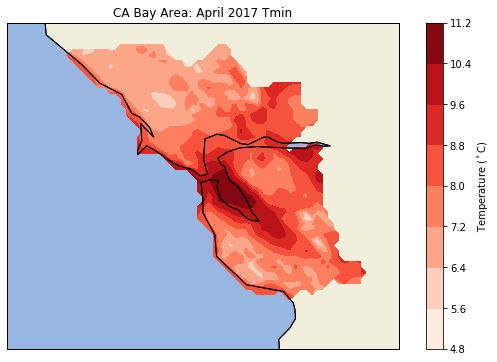

In [0]:
#Create figure
fig, ax = plt.subplots( nrows=1, ncols=1, \
                       subplot_kw={'projection': ccrs.PlateCarree()}, \
                       figsize=(10,6) )

#Add data
im = ax.contourf(longitude, latitude, array_values, cmap = 'Reds', center = 0)

#Feature addition
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'black')
ax.add_feature(cfeature.BORDERS)
ax.coastlines('50m')

# #Add only CA counties
# for county in reader.records():
#   if county.attributes['STATEFP'] == '06':
#     ax.add_geometries([county.geometry], ccrs.PlateCarree(), edgecolor = 'black', facecolor = 'none')
    
#   else:
#     continue
    
#Adjust extent of map
ax.set_extent([-124, -121, 39, 36.5])

#Color bar
cbar = plt.colorbar(im)

#Labels
ax.set_title('CA Bay Area: April 2017 Tmin')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')

plt.show()

**Extract an array of the monthly mean Tmin value in Santa Clara in 1998.**

In [0]:
#Using slice to get multiple months of data
#Just have to do this for each county in each year for each variable

(ds.tmin
 .sel(time = slice('1998-01', '1998-12'))
 .where(ds.counties == county_ids['Santa Clara'])
 .sel(lon=slice(-124, -120), lat=slice(38, 36.5)).mean(['lon', 'lat']).values)

array([ 6.8278384,  8.385528 , 11.831406 , 14.63322  , 15.778292 ,
       14.471106 ,  9.606632 ,  6.66402  ,  2.6207535], dtype=float32)

**Extract single mean Tmin value in April 1998 in Santa Clara county.**

In [0]:
#DO NOT USE SLICE for single months.
(ds.tmin
 .sel(time = '1998-04')
 .where(ds.counties == county_ids['Santa Clara'])
 .sel(lon=slice(-124, -120), lat=slice(38, 36.5)).mean().values[()])

6.8278394

**Plot the Tmin in just Santa Clara county for every month in 1998.**

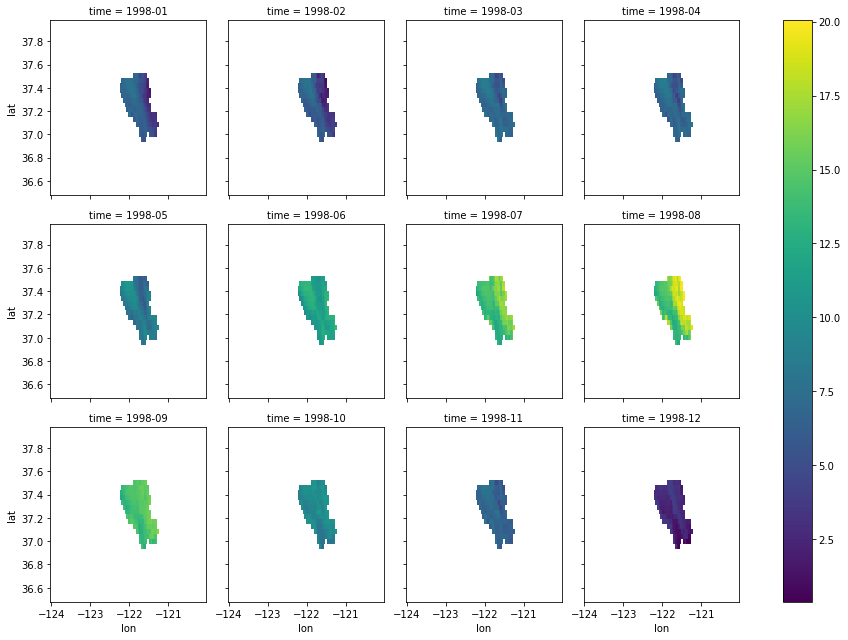

In [0]:
#Plotting for just one county
(ds.tmin
 .sel(time = slice('1998-01', '1998-12'))
 .where(ds.counties == county_ids['Santa Clara'])
 .sel(lon=slice(-124, -120), lat=slice(38, 36.5)).plot.imshow(col = 'time', col_wrap=4))

**Plot Tmax for all of Southern California for all months in 1998.**

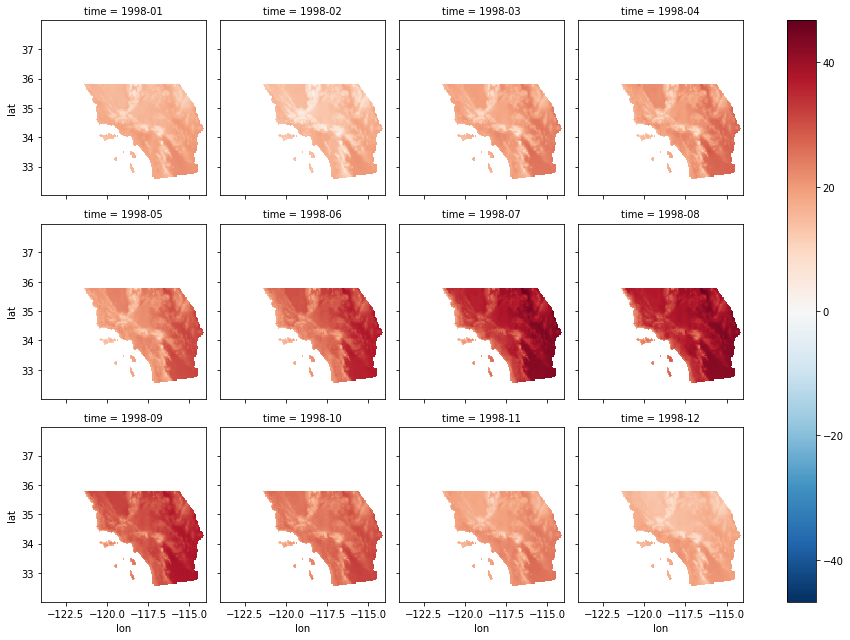

In [0]:
#Plotting for multiple, but not all, counties

counties_list = ['San Luis Obispo', 'Santa Barbara', 'Ventura', 'Kern', 'Los Angeles',
                'San Bernardino', 'Orange', 'Riverside', 'San Diego', 'Imperial']

county_fips = []
for county in counties_list:
  county_fips.append(county_ids[county])

(ds.tmax
 .sel(time = slice('1998-01', '1998-12'))
 .where(ds.counties.isin(county_fips))
 .sel(lon=slice(-124, -114), lat=slice(38, 32)).plot.imshow(col = 'time', col_wrap=4))

**We can make a better colorbar.**

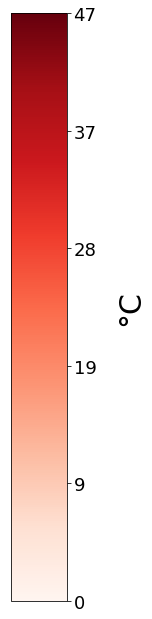

In [0]:
#Prepare figure
fig, ax = plt.subplots(figsize=(1, 12))

#Tune the subplot layout
fig.subplots_adjust(bottom=0.2)

#Select colorbar
cmap = mpl.cm.Reds

#Normalize with min and max values of data. Variables created in previous cell.
norm = mpl.colors.Normalize(vmin=np.nanmin(socal_temps.values), vmax=np.nanmax(socal_temps.values))

#Create colorbar
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')


#Degree sign unicode
degree_sign= u'\N{DEGREE SIGN}'

#Formatting label
cb1.set_label(degree_sign + 'C', fontsize = 30, labelpad = 20)

#Format ticks
cb1.set_ticks(np.linspace(np.nanmin(socal_temps.values),np.nanmax(socal_temps.values),6))
cb1.set_ticklabels(['0', '9', '19', '28', '37', '47'])
cb1.ax.tick_params(labelsize=18)

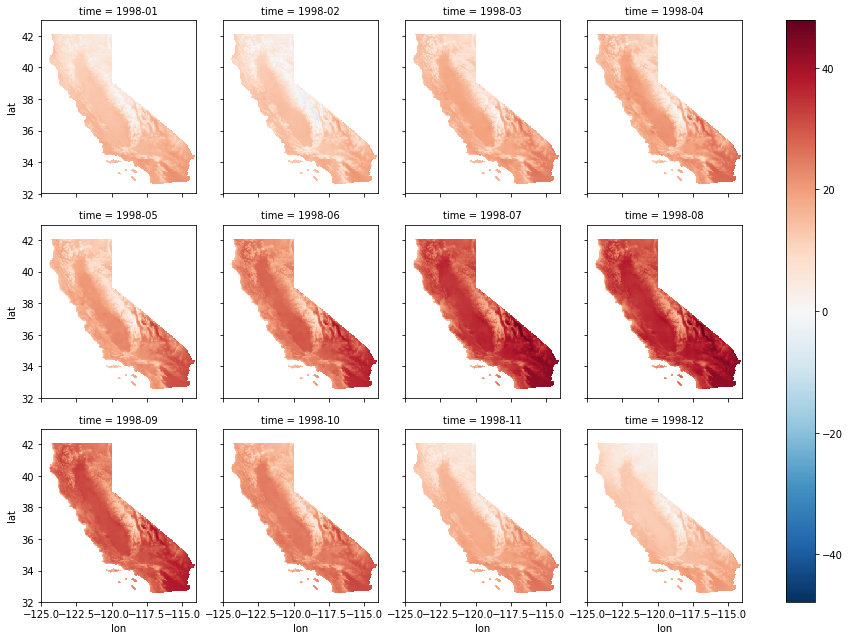

In [0]:
(ds.tmax
 .sel(time = slice('1998-01', '1998-12'))
 .where(ds.counties.isin(list(county_ids.values())))
 .sel(lon=slice(-125, -114), lat=slice(43, 32)).plot.imshow(col = 'time', col_wrap=4))

# Finding County Level Weather

We have explored PRISM data, Xarray, Xarray datasets, and masks. It is now time to extract county level weather data and save it as a clean csv file.

**Create dictionary to store information on each county. Use a multiindex (county, variable, year) for organization. Make sure to adjust the lat and lon slice to encompass all of California or else you will get NaNs for counties outside of the lat lon slice.**

In [0]:
weather_variables = ['tmax', 'tmin', 'tmean', 'vpdmax', 'vpdmin']
years = [str(i) for i in list(range(1980,2018))]

weather_dict = {}

for county in list(county_ids.keys()):
  for var in weather_variables:
    for year in years:
      if var == 'tmin':
        values =(ds.tmin.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
      elif var == 'tmax':
        values =(ds.tmax.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
      elif var == 'tmean':
        values =(ds.tmean.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
        
      elif var == 'vpdmax':
        values =(ds.vpdmax.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
      elif var == 'vpdmin':
        values =(ds.vpdmin.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
  print(county)

NameError: ignored

In [0]:
weather_variables = ['ppt', 'tmax', 'tmin', 'tmean', 'vpdmax', 'vpdmin']
years = [str(i) for i in list(range(1980,2018))]

weather_dict = {}

for county in list(county_ids.keys()):
  for var in weather_variables:
    for year in years:
      if var == 'tmin':
        values =(ds.tmin.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
      elif var == 'tmax':
        values =(ds.tmax.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
      elif var == 'tmean':
        values =(ds.tmean.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
      elif var == 'vpdmax':
        values =(ds.vpdmax.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
      elif var == 'vpdmin':
        values =(ds.vpdmin.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
      elif var == 'ppt':
        values =(ds.ppt.sel(time = slice(year+'-01', year+'-12')).where(ds.counties == county_ids[county]).sel(lon=slice(-126, -114), lat=slice(43, 32)).mean(['lon', 'lat']).values)
        weather_dict[(county,var,year)] = values
        
  print(county)

**It will be easier to have this information in a dataframe than an xarray dataset. We can always refer to the original dataset for plotting. Convert the dictionary to a dataframe and save as a csv.**

In [0]:
#Dictionary to dataframe
df = pd.DataFrame.from_dict(weather_dict, orient="index")

#Formatting multiiindex and column names as months
df.index = pd.MultiIndex.from_tuples(df.index, names = ['County', 'Var', 'Year'])
df = df.rename(columns = {0:'January', 1:'February', 2:'March', 3:'April', 4:'May',
                         5:'June', 6:'July', 7:'August', 8:'September', 9:'October',
                         10:'November', 11:'December'})

#Deconstruct multiindex for easy queries
df.reset_index(inplace = True)

#Inspect
print(df.head())

#Save as csv file
df.to_csv('county_level_weather.csv')

   County  Var  Year  ...     October    November    December
0  Sierra  ppt  1980  ...   33.582626   41.988926  120.442238
1  Sierra  ppt  1981  ...  174.779312  504.357941  377.453613
2  Sierra  ppt  1982  ...  202.075043  250.340317  253.627686
3  Sierra  ppt  1983  ...   91.135620  504.704224  429.239380
4  Sierra  ppt  1984  ...  103.931931  325.303802   62.782768

[5 rows x 15 columns]


In [0]:
#Save netCDF file to Google Drive
!cp county_level_weather.csv drive/My\ Drive/

**Let's play around a bit with the county level weather.**

In [0]:
df = pd.read_csv('county_level_weather.csv')
df.head()

,Unnamed: 0,County,Var,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,0,Sierra,ppt,1980,415.709686,382.501617,111.128197,79.320557,64.565422,22.852375,17.899927,5.491146,9.450271,33.582626,41.988926,120.442238
1,1,Sierra,ppt,1981,236.459885,113.850082,176.456726,44.330055,63.482513,3.611892,0.004392,0.003986,30.670328,174.779312,504.357941,377.453613
2,2,Sierra,ppt,1982,229.290253,221.140564,298.874725,318.278595,11.199191,37.534851,13.221622,5.106486,111.741684,202.075043,250.340317,253.627686
3,3,Sierra,ppt,1983,232.798508,369.659393,429.405151,169.349167,41.239933,30.229248,8.763040,30.967905,54.934071,91.135620,504.704224,429.239380
4,4,Sierra,ppt,1984,17.905682,185.402206,118.662277,81.836754,31.953772,41.990131,17.944529,9.015877,8.106352,103.931931,325.303802,62.782768


In [0]:
row = df.loc[(df['County'] == 'San Joaquin') & (df['Var'] == 'tmax')]
row = row.transpose()
row.rename(columns = row.loc['Year'], inplace = True)
bad = ['Unnamed: 0', 'County', 'Var', 'Year']
row = row.drop(bad)

Text(0.5, 1.0, 'Tmax San Joaquin County')

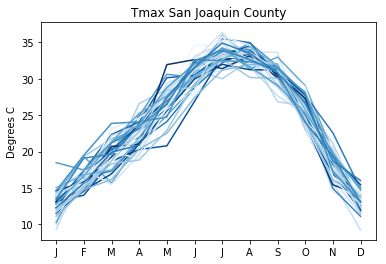

In [0]:
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.Blues(np.linspace(0,1,22)))

fig, ax = plt.subplots()

for i in list(np.arange(1980,2018,1)):
  ax.plot(row[i])
  
ax.set_ylabel('Degrees C')
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_title('Tmax San Joaquin County')

/usr/local/lib/python3.6/dist-packages/matplotlib/colorbar.py:600: UserWarning: set_ticks() must have been called.
  warnings.warn("set_ticks() must have been called.")


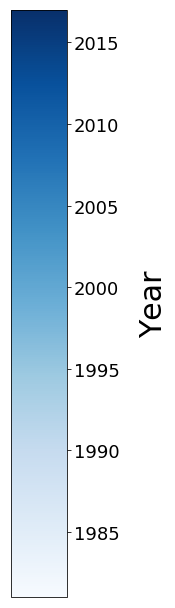

In [0]:
#Prepare figure
fig, ax = plt.subplots(figsize=(1, 12))

#Tune the subplot layout
fig.subplots_adjust(bottom=0.2)

#Select colorbar
cmap = mpl.cm.Blues

#Normalize with min and max values of data. Variables created in previous cell.
norm = mpl.colors.Normalize(vmin=1981, vmax=2017)

#Create colorbar
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

#Formatting label
cb1.set_label('Year', fontsize = 30, labelpad = 20)

#Format ticks
#cb1.set_ticks(np.linspace(1980,2017,9))
cb1.set_ticklabels(['1980'])
cb1.ax.tick_params(labelsize=18)